# Pairs Selection using CCM/KNN for Statistical Arbitrage

This notebook documents the steps taken to identify cointegrated pairs using **Convergent Cross Mapping (CCM)** and **K-Nearest Neighbors (KNN)** based similarity, with the goal of implementing a pairs trading strategy.

## Step 1: Load and Preprocess Price Data

In this step, we load historical price data for tech stocks from the SP500 from September 2024 to April 2025 to prepare it for cointegration and nonlinear similarity analysis.

We typically use daily closing prices, as they are sufficient to capture medium-term relationships between assets in a pairs trading context.

The output of this step is a clean time series dataset, where each column represents a stock and each row represents a trading day.

In [14]:
import pandas as pd
import numpy as np

# Data loaded using data.py and cleaned using clean.py

df = pd.read_csv("data/clean/train_prices_clean.csv", index_col=0, parse_dates=True)
df.head()

,AAPL,ACN,ADBE,ADI,ADSK,AMAT,AMD,ANET,ANSS,APH,...,ORCL,PANW,PLTR,QCOM,ROP,SNPS,TEL,TXN,VRSN,WDAY
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-16,215.562271,349.459076,521.500000,221.375412,267.730011,186.709839,152.080002,89.790001,318.049988,62.804119,...,168.924347,173.054993,36.310001,164.854080,554.101868,498.570007,144.643982,194.068832,182.460007,249.210007
2024-09-17,216.030609,332.603851,515.030029,223.427750,266.890015,187.715149,150.820007,90.237503,317.250000,63.684906,...,166.087952,168.964996,36.450001,166.922058,549.392761,502.250000,146.527878,196.924057,182.860001,248.119995
2024-09-18,219.916962,331.755188,508.130005,220.740860,264.209991,185.276520,148.289993,90.427498,313.390015,62.998192,...,163.172226,164.875000,36.380001,166.526276,547.501099,495.950012,144.683640,196.259171,179.270004,248.470001
2024-09-19,228.068314,330.827545,526.440002,231.458649,269.760010,195.797501,156.740005,94.830002,322.290009,64.978706,...,166.206955,166.800003,36.830002,172.087036,558.382874,514.119995,148.114319,202.996384,182.419998,247.429993
2024-09-20,227.400650,331.794647,522.299988,224.845551,267.290009,191.268616,155.949997,96.114998,320.250000,65.595757,...,166.613586,170.059998,37.200001,167.139755,555.575317,506.649994,146.855087,198.791718,181.220001,248.289993


## Step 2: Cointegration scan using Engle-granger test

The goal here is to identify pairs of assets that are **cointegrated**. This means their prices move together over time in a stable long-term relationship, despite being non-stationary individually.

We use the **Engle-Granger test**, which works as follows:
1. Run a linear regression of one asset on another to estimate the hedge ratio (β).
2. Test the residuals of that regression for stationarity using a **unit root test** (Augmented Dickey-Fuller).

If the residuals are stationary (i.e., reject the null hypothesis of a unit root), the two assets are considered **cointegrated**.

This gives us a first list of candidate pairs that might be suitable for pairs trading based on mean-reverting spread behavior.

In [16]:
from cointegration import scan_pairs
import itertools
import itertools as it
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from cointegration import scan_pairs, eagle_granger_test

pairs = scan_pairs(df, p=0.05)
if not pairs:
    print("No cointegrated pairs found in training data at p < 0.05")
else:
    out_df = pd.DataFrame(pairs, columns=["stock1","stock2","pvalue"])
    print(f"Found {len(pairs)} cointegrated pairs in training data")
    print("Training Pairs:")
    print(out_df)

Found 193 cointegrated pairs in training data
Training Pairs:
    stock1 stock2    pvalue
0     AAPL   INTC  0.003325
1     AAPL     MU  0.046456
2     AAPL    TEL  0.046849
3     AAPL   WDAY  0.042247
4      ACN   ANET  0.046493
..     ...    ...       ...
188   PANW    TEL  0.002605
189   PANW   WDAY  0.016349
190   PLTR    TEL  0.024652
191    ROP    TEL  0.018403
192   SNPS    TEL  0.033342

[193 rows x 3 columns]


## Step 3: Compute the CCM filter to filter the pairs having nonlinear relationships

While cointegration tests capture linear long-term relationships, they can miss nonlinear or lagged dependencies that exist between asset prices.

To capture such complex interactions, we apply **Convergent Cross Mapping (CCM)** — a method from nonlinear dynamical systems theory.

**CCM works by:**
- Creating delay embeddings of time series to reconstruct their state-space behavior.
- Measuring how well the past of one time series can predict the present of another using **K-Nearest Neighbors (KNN)**.
- Evaluating whether prediction skill converges as more data is used — a sign of dynamic coupling.

By applying CCM, we filter the cointegrated pairs and retain only those with strong nonlinear dependencies, giving us higher-quality candidates for pairs trading.

This step helps us go beyond linear statistics and tap into hidden structure that may provide stronger trading signals.

The heatmap of CCM scores provides a visual representation of the cross-mapping skill between asset pairs. By comparing these scores with the cointegration p-values, we can identify the pairs that exhibit both strong nonlinear coupling and statistical cointegration, allowing us to select the most promising candidates for our trading strategy.

In-sample CCM-filtered pairs:
   stock1 stock2      r_xy      r_yx
0    ADBE    HPQ  0.836558  0.836557
1    ADSK   ANSS  0.822759  0.822758
2    ADSK    APH  0.832018  0.832016
3    ADSK   CDNS  0.822889  0.822889
4    ADSK    CRM  0.868959  0.868959
5    ADSK    MSI  0.815529  0.815529
6     AMD   MCHP  0.912829  0.912829
7    ANSS    APH  0.837926  0.837926
8    ANSS    CRM  0.867640  0.867640
9    ANSS   GDDY  0.806158  0.806157
10   ANSS    NOW  0.833649  0.833649
11    APH   CDNS  0.851589  0.851589
12   CDNS    CRM  0.827928  0.827929
13   CDNS    NOW  0.875635  0.875635
14    CRM   WDAY  0.803878  0.803878
15   CRWD   CTSH  0.808502  0.808502
16   CRWD   FTNT  0.928104  0.928103
17   CRWD    GLW  0.839700  0.839699
18   CRWD   PLTR  0.930508  0.930507
19   CSCO   FTNT  0.935126  0.935128
20   CSCO   PLTR  0.905552  0.905552
21   CTSH   FTNT  0.827336  0.827336
22   DELL    HPQ  0.927943  0.927942
23   DELL   NVDA  0.803472  0.803471
24   DELL   ORCL  0.831319  0.831320
25   FIC

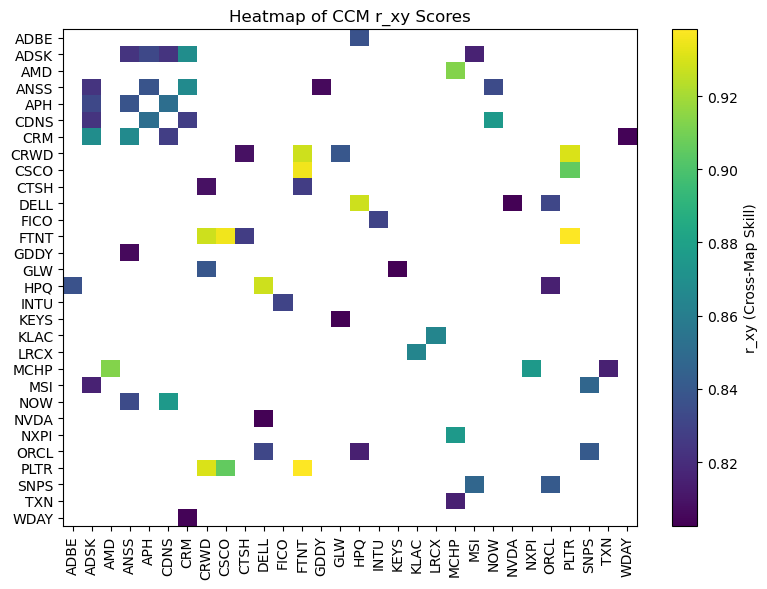

In [23]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import zscore, pearsonr
from ccm_filter import filter_ccm
import matplotlib.pyplot as plt

pairs = pd.DataFrame(
    pairs,
    columns=["stock1","stock2","pvalue"]
)

# Backtested in train_ccm to find the best embedding dimension E and neighbors k
good = filter_ccm(df, pairs, E=4, tau=1, k=5, r_tresh=0.8)
out = pd.DataFrame(good, columns=["stock1","stock2","r_xy","r_yx"])
print("In-sample CCM-filtered pairs:")
print(out)

# Heatmap for visualization

tickers = sorted(set(out['stock1']).union(out['stock2']))
matrix = pd.DataFrame(np.nan, index=tickers, columns=tickers)

for _, row in out.iterrows():
    t1, t2, r_xy, r_yx = row['stock1'], row['stock2'], row['r_xy'], row['r_yx']
    matrix.loc[t1, t2] = r_xy
    matrix.loc[t2, t1] = r_yx  # mirror for symmetry

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(matrix.values, aspect='auto', interpolation='nearest')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('r_xy (Cross-Map Skill)')

ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers, rotation=90)
ax.set_yticklabels(tickers)
ax.set_title('Heatmap of CCM r_xy Scores')

plt.tight_layout()
plt.show()